В проекте используется обезличенный датасет с информацией о бронированиях в курортном отеле.

**Источник данных:** https://www.sciencedirect.com/science/article/pii/S2352340918315191#s0005 (Nuno Antonio, Ana de Almeida, Luis Nunes, Hotel booking demand datasets, Data in Brief, Vol. 22, 2019, P. 41-49, ISSN 2352-3409, https://doi.org/10.1016/j.dib.2018.11.126)

In [122]:
# !pip install catboost
# !pip install optuna
# !pip install category_encoders

In [26]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_val_score
from category_encoders.leave_one_out import LeaveOneOutEncoder
palette = ["#2ECC71", "#C70039", "#3A0CA3", "#4361EE", "#4CC9F0"]
sns.set_palette(palette)

## 1. Считывание данных <a class="anchor" id="first-bullet">

In [25]:
folder_path = os.getcwd()
df = pd.read_csv(os.path.join(Path(folder_path).parent, 'Hotels/H1.csv'))
# df.sample(5)

## 2. EDA

### 2.1  Тип данных и наличие пропусков

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40060 entries, 0 to 40059
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   40060 non-null  int64  
 1   LeadTime                     40060 non-null  int64  
 2   ArrivalDateYear              40060 non-null  int64  
 3   ArrivalDateMonth             40060 non-null  object 
 4   ArrivalDateWeekNumber        40060 non-null  int64  
 5   ArrivalDateDayOfMonth        40060 non-null  int64  
 6   StaysInWeekendNights         40060 non-null  int64  
 7   StaysInWeekNights            40060 non-null  int64  
 8   Adults                       40060 non-null  int64  
 9   Children                     40060 non-null  int64  
 10  Babies                       40060 non-null  int64  
 11  Meal                         40060 non-null  object 
 12  Country                      39596 non-null  object 
 13  MarketSegment   

Проверим наличие пропусков

In [7]:
nans = df.isna().sum()
nans[nans>0]

Country      464
Agent       8209
Company    36952
dtype: int64

Видим, что пропуски присутствуют в 3-х колонках. В колонке Country и их количество составляет 1.16%.
В колонках Agent и Company 20.49% и 92.24% соответственно.

### 2.2 Категориальные признаки

In [8]:
df.describe(include='object')

,ArrivalDateMonth,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,CustomerType,ReservationStatus,ReservationStatusDate
count,40060,40060,39596,40060,40060,40060,40060,40060,40060,40060,40060
unique,12,5,125,6,4,10,11,3,4,3,913
top,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2017-01-19
freq,4894,30005,17630,17729,28925,23399,17046,38199,30209,28938,147


В датасете 11 категориальных признаков, причем в большинстве из них большое число категорий.

Рассмотрим подробнее отдельные признаки

**ReservationStatus, ReservationStatusDate**

In [9]:
df.ReservationStatus.value_counts()

Check-Out    28938
Canceled     10831
No-Show        291
Name: ReservationStatus, dtype: int64

Данные в колонке ReservationStatus содержат информацию о том, как завершилось бронирование, поэтому ее нужно будет удалить, а вместе с ней и колонку ReservationStatusDate.

**Company**

In [10]:
df.Company.value_counts()

223.0    784
281.0    138
154.0    133
405.0    100
94.0      87
        ... 
10.0       1
246.0      1
413.0      1
408.0      1
410.0      1
Name: Company, Length: 235, dtype: int64

В столбце **Company** присутствуют значение NULL (отсутствие компании-заказчика, т.е. индивидуальный заказчик). Эти значения будут заменены на 0.

**CustomerType**

In [11]:
df.CustomerType.value_counts()

Transient          30209
Transient-Party     7791
Contract            1776
Group                284
Name: CustomerType, dtype: int64

**MealType**


In [12]:
df.Meal.value_counts()

BB           30005
HB            8046
Undefined     1169
FB             754
SC              86
Name: Meal, dtype: int64

### 2.3 Корреляционная зависимость признаков

<ipython-input-13-9a7a0a58728a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

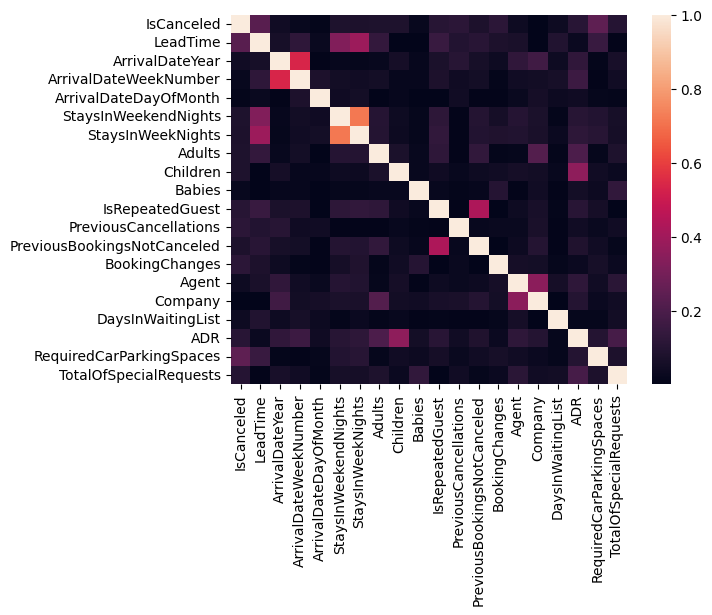

In [13]:
corr = df.corr()
sns.heatmap(corr.abs())

Видим наличие слабой корреляционной зависимости целевой переменной с показателями LeadTime (дней между датой бронирования и прибытием) RequiredCarSpaces (кол-во требуемых парковочных мест).
Ожидаемо присутствие корреляционной зависимости между колонками IsRepeatedGuest и PreviousBookingsCancelations.

### 2.4 Процент отмененных бронирований в сопоставлении с отдельными признаками

In [14]:
category_columns = ['ArrivalDateMonth', 'Meal',  'MarketSegment',
                    'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
                    'DepositType', 'CustomerType']

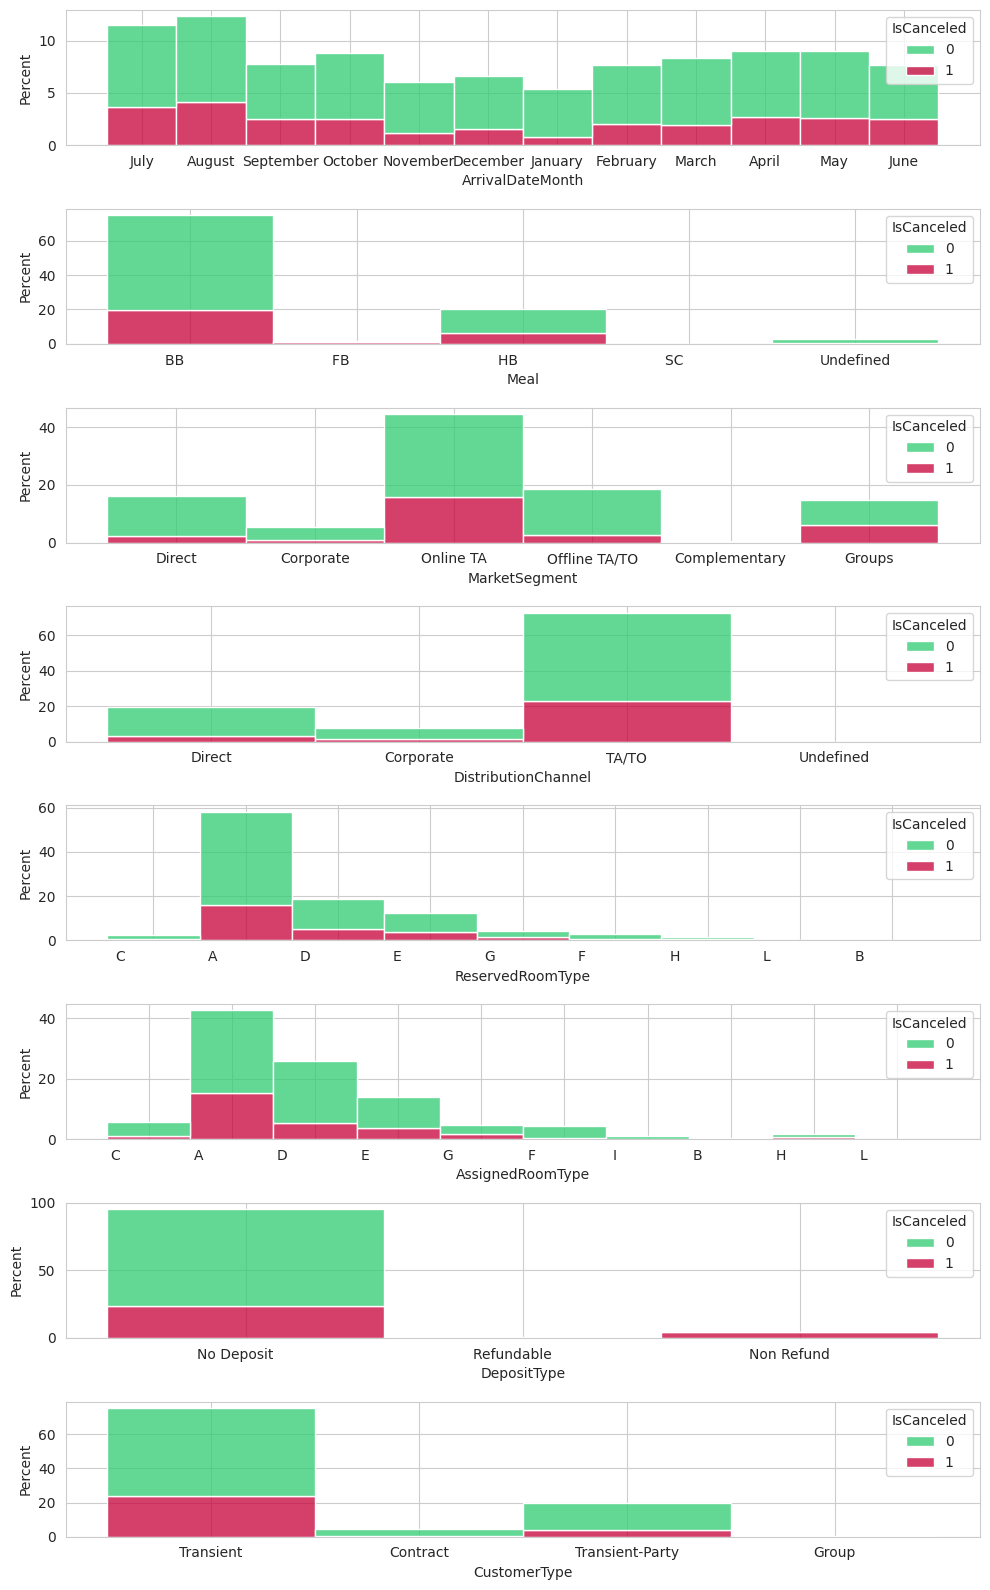

In [35]:
fig, axes = plt.subplots(len(category_columns), 1, figsize=(10, 16), tight_layout=True)

# sns.histplot(data=df, x='ArrivalDateMonth', hue='IsCanceled',  discrete=True, multiple='stack', ax=axes[0])
for i in np.arange(len(category_columns)):
    sns.histplot(data=df, x=category_columns[i], hue='IsCanceled',  discrete=True, multiple='stack', ax=axes[i], stat='percent')

### 2.5 Распределение целевой переменной
Проверим, сбалансированы ли классы

<Axes: xlabel='IsCanceled', ylabel='Count'>

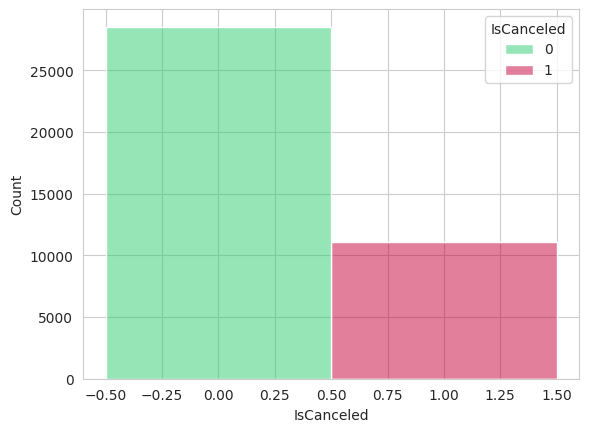

In [34]:
sns.histplot(data=df, x='IsCanceled', discrete=True, hue='IsCanceled')

Присутствует значительный дисбаланс классов (ожидаемо в данной задаче), что влияет на обучение и оценку качества модели.
С учетом этого, будем использовать метрики **ROC-AUC**, **precision/recall**, **f1**. 

## 3. Обработка пропусков и выбросов, удаление лишних столбцов, преобразование типов.

1\. В колонке Company значительное количество пропусков, означающее отсутствие компании-заказчика (т.е. индивидуальный заказчик), поэтому колонку не удаляем, а заменяем пропуски в колонке Company на 0.
Аналогично, пропуск в колонке Agent обозначает отсутствие агента. Замение эти пропуски на 0.

In [21]:
df.Company = df.Company.fillna(0)
df.Agent = df.Agent.fillna(0)

2\. Поскольку в колонке Country пропущено 464 значения (1.16%), просто удалим строки с пропусками.

In [22]:
df = df.dropna()

3\. Переведем значения в колонках Company и Agent в целочисленный тип

In [23]:
df[['Company', 'Agent']] = df[['Company', 'Agent']].astype(int)

4\. Удалим колонки Reservation status и ReservationStatusDate

In [24]:
df = df.drop(['ReservationStatus', 'ReservationStatusDate'], axis=1)

## 4. Разбиение данных на обучающую и тестовые выборки

Разобъем выборку на обучающую (70% данных), валидационную (20%) и  тестовую (10%)

In [25]:
X = df.drop('IsCanceled', axis=1)
y = df.IsCanceled

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, random_state=5)

## 5. Выбор модели

### 5.3 Логистическая регрессия

#### 5.3.1 Кодирование категориальных признаков

Закодируем признаки для логистической регрессии. Поскольку категориальные признаки содержат большое число категорий, будем использовать кодирование счетчиками по LOO кросс-валидации, чтобы избежать добавления большого числа новых столбцов.

****

In [40]:
cat_cols = ['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
            'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
            'DepositType', 'Agent', 'Company', 'CustomerType'
            ]

In [64]:
loo_enc = LeaveOneOutEncoder(sigma=0.3) #  сигма - шум для снижения переобучения
loo_enc.fit(X_train[cat_cols], y_train)
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
X_val_encoded = X_val.copy()
X_train_encoded[cat_cols] = loo_enc.transform(X_train_encoded[cat_cols])
X_test_encoded[cat_cols] = loo_enc.transform(X_test_encoded[cat_cols])
X_val_encoded[cat_cols] = loo_enc.transform(X_val_encoded[cat_cols])

#### 5.3.2 Нормализация численных признаков

In [65]:
cols_to_normalize = X.select_dtypes(['int', 'float']).columns
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train_encoded[cols_to_normalize])

X_train_encoded[cols_to_normalize] = minmax_scaler.transform(X_train_encoded[cols_to_normalize])
X_test_encoded[cols_to_normalize] = minmax_scaler.transform(X_test_encoded[cols_to_normalize])
X_val_encoded[cols_to_normalize] = minmax_scaler.transform(X_val_encoded[cols_to_normalize])

#### 5.3.3 Подбор гиперпараметров для логистической регрессии

Применим логистическую регрессию с параметрами по умолчанию

In [66]:
# lr =LogisticRegression(C=100, solver='liblinear', penalty='l1', max_iter=1000, class_weight='balanced', random_state=42)
lr_basic = LogisticRegression(max_iter=150, random_state=42)
lr_basic.fit(X_train_encoded, y_train)
lr_basic_predictions = lr_basic.predict(X_val_encoded)
print('Логистическая регрессия со стандартными параметрами')
print(f'F1: {round(f1_score(y_val, lr_basic_predictions), 4)}')
print(f'Recall: {round(recall_score(y_val, lr_basic_predictions), 4)}')
print(f'Precision: {round(precision_score(y_val, lr_basic_predictions), 4)}')

Логистическая регрессия со стандартными параметрами
F1: 0.6751
Recall: 0.6013
Precision: 0.7696


Подберем параметры с помощью поиска по сетке

In [46]:
params = {'penalty': ['l1', 'l2'],
          'C': [1, 10, 50, 100],
          'solver': ['liblinear', 'saga'],
          'class_weight': ['balanced', None]
          }
grid = GridSearchCV(estimator=LogisticRegression(random_state=5), param_grid=params, n_jobs=-1, scoring='roc_auc', refit=True)
grid.fit(X_train_encoded, y_train)
print(f'Лучшие параметры: {grid.best_params_}')

Лучшие параметры: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [47]:
lr = LogisticRegression(C=100, class_weight='balanced', penalty='l1', solver='liblinear', random_state=5)
lr.fit(X_train_encoded, y_train)
lr_predictions = lr.predict(X_val_encoded)
print(f'Логистическая регрессия с подобранными параметрами')
print(f'ROC-AUC: {round(roc_auc_score(y_val, lr_predictions), 4)}')
print(f'F1: {round(f1_score(y_val, lr_predictions), 4)}')
print(f'Recall: {round(recall_score(y_val, lr_predictions), 4)}')
print(f'Precision: {round(precision_score(y_val, lr_predictions), 4)}')

Логистическая регрессия с подобранными параметрами
ROC-AUC: 0.8112
F1: 0.7025
Recall: 0.8169
Precision: 0.6163


Подбор гиперпараметров для логистической регрессии позволил заметно улучшить качество классификации

### 5.1 Catboost. Подбор гиперпараметров и обучение модели

Подберем гиперпараметры для CatBoostClassifier и обучим модель

In [48]:
def objective_catboost(trial):
    max_depth = trial.suggest_int("max_depth", 4, 16)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    n_estimators = trial.suggest_int("n_estimators", 10, 500)

    score = cross_val_score(CatBoostClassifier(max_depth=max_depth, learning_rate=learning_rate,
                                               n_estimators=n_estimators, cat_features=cat_cols, random_state=5),
                            X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)

In [ ]:
study.best_params

{'max_depth': 10, 'learning_rate': 0.052784978973967556, 'n_estimators': 403}

In [ ]:
study.best_value

0.9623375854710478

In [77]:
boost_model = CatBoostClassifier(max_depth=10, learning_rate=0.053, n_estimators=403, cat_features=cat_cols, random_state=5, verbose=False)
boost_model.fit(X_train, y_train)

Проверим работу модели на валидационной выборке:

In [68]:
pred_val = boost_model.predict(X_val)
print(f'ROC-AUC: {round(roc_auc_score(y_val, pred_val), 4)}')
print(f'Precision: {round(precision_score(y_val, pred_val), 4)}')
print(f'Recall: {round(recall_score(y_val, pred_val), 4)}')
print(f'F1: {round(f1_score(y_val, pred_val), 4)}')

ROC-AUC: 0.8874
Precision: 0.846
Recall: 0.8351
F1: 0.8405


In [69]:
importance = pd.DataFrame()
importance['feature'] = X_train.columns
importance['importance'] = boost_model.feature_importances_
# importance.sort_values(by=['importance'], ascending=False)

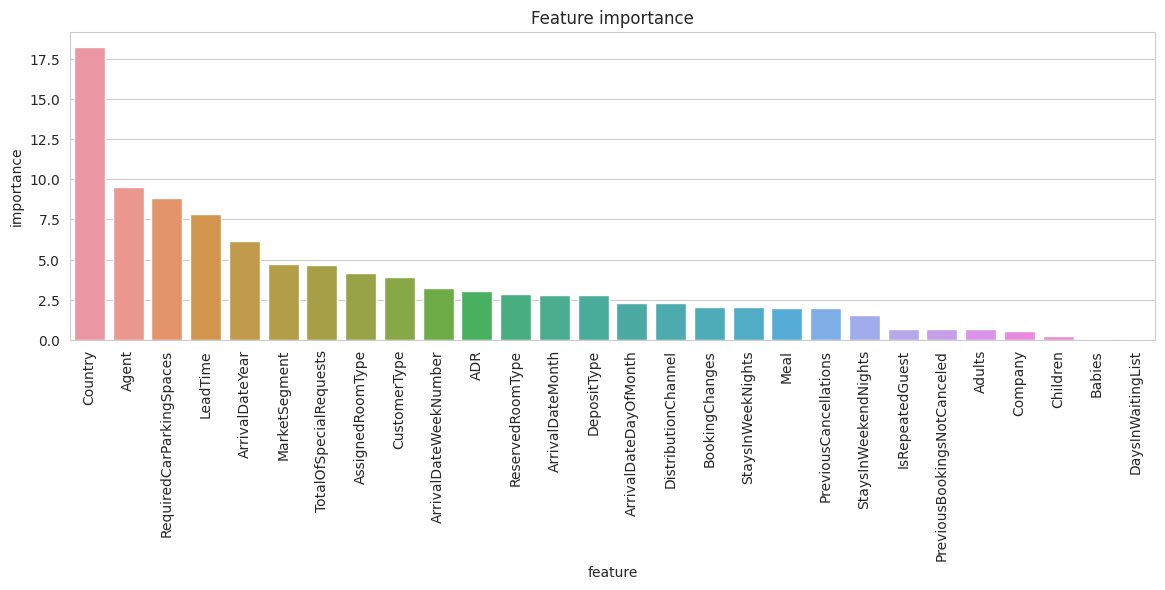

In [70]:
fig = plt.figure(figsize=(14, 4))
# sns.set_theme()
sns.set_style("whitegrid")
sns.barplot(data=importance.sort_values(by=['importance'], ascending=False), x='feature', y='importance').set_title('Feature importance')
plt.xticks(rotation=90)
plt.show()

### 5.2 Отбор значимых признаков для CatBoost

Попробуем упростить модель и повысить качество предсказания, удалив колонки с наименьшей значимостью: **Babies** и **DaysInWaiingList**.

In [71]:
X_train = X_train.drop(['Babies', 'DaysInWaitingList'], axis=1)
X_val = X_val.drop(['Babies', 'DaysInWaitingList'], axis=1)

Подберем гиперпараметры для упрощенной модели

In [ ]:
study_without_insignificant_col = optuna.create_study(direction="maximize")
study_without_insignificant_col.optimize(objective_catboost, n_trials=30)

In [ ]:
print(study_without_insignificant_col.best_value, study_without_insignificant_col.best_params)

0.9623710289835669 {'max_depth': 9, 'learning_rate': 0.07087870514041347, 'n_estimators': 498}


Обучим модель и получим предсказания

In [72]:
boost_model_without_unsignificant = CatBoostClassifier(max_depth=9, learning_rate=0.071, n_estimators=498, 
                                                      cat_features=cat_cols, random_state=5, verbose=False)
boost_model_without_unsignificant.fit(X_train, y_train)
cb_pred_w = boost_model_without_unsignificant.predict(X_val)

Проверим качество упрощенной модели на валидационной выборке

In [73]:
print(f'ROC-AUC: {round(roc_auc_score(y_val, cb_pred_w), 5)}')
print(f'F1: {round(f1_score(y_val, cb_pred_w), 5)}')
print(f'Recall: {round(recall_score(y_val, cb_pred_w), 5)}')
print(f'Precision: {round(precision_score(y_val, cb_pred_w), 5)}')

ROC-AUC: 0.88726
F1: 0.84004
Recall: 0.83556
Precision: 0.84456


После удаления 2-х малозначимых признаков метрики изменились незначительно.

### 5.4 Сравнение качества работы моделей на тестовой выборке

Логистическая регрессия

In [74]:
lr_predictions_test = lr.predict(X_test_encoded)
print('Логистическая регрессия')
print(f'F1: {round(f1_score(y_test, lr_predictions_test), 4)}')
print(f'Recall: {round(recall_score(y_test, lr_predictions_test), 4)}')
print(f'Precision: {round(precision_score(y_test, lr_predictions_test), 4)}')

Логистическая регрессия
F1: 0.6895
Recall: 0.8115
Precision: 0.5993


Градиентный бустинг Catboost

In [75]:
boost_predictions_test = boost_model.predict(X_test)
print('Градиентный бустинг со всеми признаками')
print(f'F1: {round(f1_score(y_test, boost_predictions_test), 4)}')
print(f'Recall: {round(recall_score(y_test, boost_predictions_test), 4)}')
print(f'Precision: {round(precision_score(y_test, boost_predictions_test), 4)}')

Градиентный бустинг со всеми признаками
F1: 0.8258
Recall: 0.8307
Precision: 0.821


In [76]:
boost_predictions_reduced_test = boost_model_without_unsignificant.predict(X_test.drop(['Babies', 'DaysInWaitingList'], axis=1))
print('Градиентный бустинг без малозначимых признаков')
print(f'F1: {round(f1_score(y_test, boost_predictions_reduced_test), 4)}')
print(f'Recall: {round(recall_score(y_test, boost_predictions_reduced_test), 4)}')
print(f'Precision: {round(precision_score(y_test, boost_predictions_reduced_test), 4)}')

Градиентный бустинг без малозначимых признаков
F1: 0.8278
Recall: 0.8335
Precision: 0.8222


На тестовой выборке лучший результат показала модель градиентного бустинга без использования малозначимых признаков. Этот вариант позволяет получить более простую модель за счет сокращения количества признаков, при этом не теряя в качестве классификации.